In [251]:
from itertools import product, islice
from typing import Dict, List, Any, Tuple, Callable
import os
import pickle
from timeit import default_timer as timer
import math

import numpy as np
import matplotlib.pyplot as plt

from IOData.IOData import InputRule
from IOData.IODataWith_l import IODataWith_l

from simulators.track_simulator import TrackSimulator
from simulators.simulation_settings import SafetyFilterTypes, TrackFilterTypes, SimulationInputRule, ModelType
from tools.simualtion_results import Results

from tools.simple_track_generator import trackGenerator
from tools.FractalDimension import fractal_dimension
from tools.monte_carlo_integral import monte_carlo_integrate
from tools.dataset_analyse import weighting_xi_in_datasets, weighting_u_pf_y_p_in_datasets, get_datasets_hankel_matrix, Sampler, from_deg_to_rad

In [252]:
# read results from file
results_file_name = '10-26_13_23-results_list.pkl'
with open(os.path.join(os.curdir, 'datasets', results_file_name), 'rb') as f:
    results_list: List[Results] = pickle.load(f)

In [253]:
dataset_name_list: List[str]  = [
    # '01-05-09-04-56-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-05-09-11-40-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-05-09-21-56-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-05-09-34-32-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-05-09-47-49-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-05-10-01-36-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-05-10-15-50-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-05-10-30-48-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-05-10-46-30-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-05-11-02-36-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-05-11-19-28-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-05-11-36-46-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-05-11-54-41-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-05-12-12-40-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-05-12-31-21-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-05-12-50-47-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',

    # '01-08-04-37-28-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-08-04-48-09-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-08-05-00-41-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-08-05-13-54-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-08-05-27-36-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-08-05-40-54-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-08-05-54-54-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',

    # '01-11-15-06-56-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',

    # '01-11-15-47-13-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',

    # '01-10-19-11-02-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-10-19-19-04-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-10-19-27-22-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-10-19-35-27-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # # '01-10-19-49-28-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-10-19-53-31-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-10-20-00-38-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-10-20-08-08-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-10-20-15-30-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    
    #With mixture of sine and random, using "SINE_WITH_MEAN_RANDOM" and mean steering 1.7*kinmeatic steering
    #Short but good enough dataset
    '01-11-15-51-43-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    '01-11-15-53-53-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    '01-11-15-56-17-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    '01-11-15-58-59-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    '01-11-16-01-46-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    '01-11-16-04-47-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    '01-11-16-08-06-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',

    #With mixture of sine and random, using "SINE_WITH_MEAN_RANDOM" and mean steering 1.7*kinmeatic steering
    #Maybe too long than needed
    # '01-12-12-58-07-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-12-13-04-25-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-12-13-10-47-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-12-13-15-12-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-12-13-18-09-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-12-13-21-30-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-12-13-25-28-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # # might be useless from here
    # '01-12-13-28-59-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-12-13-32-38-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-12-13-36-27-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-12-13-40-22-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-12-13-45-02-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',

    #With mixture of sine and random, using "RANDOM_WITH_MEAN" and mean steering 1.7*kinmeatic steering
    #Maybe too long than needed
    # '01-12-14-02-35-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-12-14-05-17-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-12-14-08-01-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-12-14-10-42-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-12-14-13-25-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-12-14-16-20-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-12-14-19-30-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-12-14-22-53-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # might be useless from here
    # '01-12-14-26-22-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-12-14-30-11-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    # '01-12-14-34-21-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl',
    '01-12-14-38-35-half_round_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA_WITH_L.pkl', # larger prediction error but smaller lap time, why?????
]

In [254]:
len(dataset_name_list)

8

In [255]:
# parameters for analysis stored in Sampler
sampler = Sampler()
sampler.l_p = 10
sampler.l_f = 85

# results and dataset index to analyse
results_index = range(5, 24, 4)
dataset_list: List[List[List[IODataWith_l]]] = []
for i in range(len(dataset_name_list)):
    with open(os.path.join(os.curdir, 'datasets', dataset_name_list[i]), 'rb') as f:
        single_dataset_list: List[List[IODataWith_l]] = pickle.load(f)
    dataset_list.append(single_dataset_list)

# get output and input size
m = dataset_list[0][0][0]._input_data[0].shape[0]
p = dataset_list[0][0][0]._output_data[0].shape[0]

# # extended state to analyse
# state_index = 159
# results = results_list[results_index[0]]
# t_proposed = (state_index+1) * results.Ts
# u_list, y_list = [], []
# for i in range(state_index-sampler.l_p+1, state_index+1):
#     u_list.append(results._input_applied[i])
#     y_list.append(from_deg_to_rad(results._error_trajectory[i][:p]))
# xi_to_analyse = np.hstack(u_list + y_list)
# # print(xi_to_analyse)

# # extended state with future input to analyse. use the 
# u_future_list = []
# index_proposed = [trajectory_slice[0] for trajectory_slice in results._proposed_input_slices].index(t_proposed)
# list_proposed_u = results._proposed_input_slices[index_proposed][1]
# for i in range(sampler.l_f):
#     u_future_list.append(list_proposed_u[i])
# u_pf_y_p_to_analyse = np.hstack(u_list + u_future_list + y_list)
# # print(u_pf_y_p_to_analyse)

# # index of segment to analyse
# i_seg = results._segment_index_list[state_index]
# print(i_seg)

results_list_to_analyse = [results_list[i] for i in results_index]
# results_list_to_analyse = results_list
dataset_list_to_analyse = dataset_list
# print(len(results_list_to_analyse))
print(len(dataset_list_to_analyse))
for datasets_for_segments in dataset_list_to_analyse:
    print(len(datasets_for_segments))
# len(results_list_to_analyse[0]._error_trajectory_slices)

8
2
2
2
2
2
2
2
2


In [256]:
for result in results_list_to_analyse:
    print(len(result._predicted_error_with_slack_slices))
    error_list = np.ndarray(shape = (0,))
    for  prediction_with_slack, real_trajectory in zip(result._predicted_error_with_slack_slices, result._error_trajectory_slices):
        prediction_with_slack = np.hstack(prediction_with_slack[1][0:20])
        real_trajectory = np.hstack(real_trajectory[1][0:20])
        error_list = np.hstack((error_list, prediction_with_slack-real_trajectory))
    error = np.linalg.norm(error_list, ord=np.inf)
    print(error)

16
19.63518632514474
13
26.050887985758642
10
18.363316789291538
13
11.143952177054192
10
9.677191515067262


In [257]:
H_uy_noised, _ = get_datasets_hankel_matrix(dataset_list[-1][1], lag=1, L=0)
locs = np.array(H_uy_noised[m:].T)
region_min = np.min(locs, axis=0)
region_max = np.max(locs, axis=0)
print(region_min)
print(region_max)

[-0.37335132 -0.66002107 -0.06920286 -0.09888874 -0.16360312]
[0.31991381 1.02651609 1.64954666 0.16937464 3.03937756]


In [258]:
dataset_list_for_seg = dataset_list_to_analyse[-1][0]
for io_data in dataset_list_for_seg[-1:-7:-1]:
    print(io_data.length)
    print(io_data._input_data[0:10])
    # print('\n')

144
[matrix([[0.86580606],
        [0.39981353]]), matrix([[0.53018776],
        [0.39998709]]), matrix([[0.45283232],
        [0.39999371]]), matrix([[0.20351026],
        [0.35932655]]), matrix([[0.57685704],
        [0.32303298]]), matrix([[0.45455259],
        [0.21129944]]), matrix([[0.99525124],
        [0.3447166 ]]), matrix([[0.24161914],
        [0.28489248]]), matrix([[0.28734458],
        [0.04091779]]), matrix([[0.95484928],
        [0.38244274]])]
148
[matrix([[0.91640288],
        [0.39997106]]), matrix([[0.81316463],
        [0.39990496]]), matrix([[0.05020073],
        [0.14276422]]), matrix([[0.21886768],
        [0.34771768]]), matrix([[0.99539303],
        [0.0373809 ]]), matrix([[0.27829208],
        [0.25202296]]), matrix([[0.43100082],
        [0.28068984]]), matrix([[0.41215309],
        [0.26930852]]), matrix([[0.26622346],
        [0.27191075]]), matrix([[0.99543104],
        [0.02671071]])]
160
[matrix([[0.],
        [0.]]), matrix([[0.],
        [0.]]), matri

In [259]:
from simulators.track_simulator import TrackSimulator
from tools.predictors import DynamicModelPredictorWith_l
from scipy.linalg import block_diag
i_seg = 1

dataset_list_for_seg = dataset_list_to_analyse[-1][i_seg]

simulator = TrackSimulator()
simulator.a_d_max = 2
simulator.delta_d_max = 0.12
simulator.use_saved_data = False
simulator.save_data = True
simulator.simulate_model_type = ModelType.DYNAMIC_WITH_L
simulator.data_model_type = ModelType.DYNAMIC_WITH_L
simulator.filter_model_type = ModelType.DYNAMIC_WITH_L
simulator.t_sim = 3.5
# simulator.t_sim = 0.1
simulator.num_predicted_traj = 10
simulator.global_initial_state = np.array([0.0, 0.0, 0.0, 0.3, 0.0, 0.0])
simulator.cur = 1/1.0
simulator.track_fun_name = 'half_round_track'
simulator.lag = 10
simulator.save_predicted_traj = True
simulator.save_dataset_after = True
simulator.delete_dataset_after = True
simulator.v_x_max = 2.7

simulator.t_data = 10.0
t_new_data = simulator.t_data * 0.6
simulator.data_input_rule = InputRule.PRBS_TIMES_RANDOM_MEAN

# simulator.n_v_max = 0
simulator.n_x, simulator.n_y, simulator.n_psi, simulator.n_v = 0,0,0,0
simulator.n_e_lat_max, simulator.n_mu_max, simulator.n_v_max, simulator.n_l_max = 0,0,0,0 # for test of prediction error

random_seed = 0
track_filter_type = TrackFilterTypes.SINGLE_SEGMENT
filter_type = SafetyFilterTypes.INDIRECT_FIX_MU_WEIGHTING_ADD_DATA
simulator.noise_list_dict = {}
simulator.random_seed = random_seed
simulator.noise_list_dict[random_seed] = simulator.get_noise()
simulator.track_filter_type = track_filter_type
simulator.filter_type_list = [filter_type] # reserve for using different filter types for segments
simulator.simulation_input_type = filter_type

simulator.get_utilities_for_simualtion(0)
systems = simulator.systems

lag = 10
L = 80
weight_y = np.linalg.inv(np.diag([
    simulator.track_width,
    simulator.mu_max-simulator.mu_min,
    simulator.v_x_max-simulator.v_x_min,
    simulator.v_y_max-simulator.v_y_min,
    simulator.Ts*simulator.v_0*L
    ])**2)
weight_u = np.linalg.inv(np.diag([
    simulator.a_max-simulator.a_min,
    2*simulator.delta_max])**2)
weight_xi = np.matrix(block_diag(*((weight_u,)*lag + (weight_y,)*lag)))
predictor = DynamicModelPredictorWith_l(
    dynamic_error_model=systems[i_seg],
    sampler=Sampler(),
    L = L,
    lag = lag,
    weight_xi = weight_xi,
    f = lambda d: 1/(1.1*d)**2,
    d_range = 0.1,
    min_num_slices = 450,
    portion_slices = 0.4,
    io_data_list = dataset_list_for_seg,
    weight_y=weight_y,
    use_zero_l_initial_condition=True,
)
predictor.sampler.v_0 = simulator.v_0
predictor.sampler.delta_v_x_max = simulator.v_x_max - simulator.v_0
predictor.sampler.delta_v_x_min = simulator.v_x_min - simulator.v_0

n_states = 100
n_datasets = len(dataset_list_to_analyse)
predictor.sample_state_and_input(n_states)

error_lists_datasets = np.empty(shape=(0, predictor.L))
plain_error_lists_datasets = np.empty(shape=(0, predictor.L))

# n_datasets = 5
for io_data_lists in dataset_list_to_analyse[-n_datasets:]:
    predictor.io_data_list = io_data_lists[i_seg]
    print([io_data.length for io_data in io_data_lists[i_seg]])

    # predictor.f = lambda d: 1/(1.1*d)**2
    # predictor.f = lambda d: 1/d
    # predictor.f = lambda d: np.exp(-np.sqrt(d))
    # predictor.f = lambda d: np.exp(-d**2) + 5
    predictor.f = lambda d: 1
    predictor.d_range = 10.0
    predictor.min_num_slices = 150
    predictor.portion_slices = 0.01
    method_dict, state_error_list = predictor.get_prediction_error()
    mean_error_list = np.nanmean(state_error_list, axis=0)
    error_lists_datasets = np.vstack((error_lists_datasets, mean_error_list))
    print(method_dict)

    predictor.f = lambda d: 1
    predictor.d_range = np.inf
    predictor.min_num_slices = 1
    predictor.portion_slices = 0.01
    method_dict, plain_state_error_list = predictor.get_prediction_error()
    plain_mean_error_list = np.nanmean(plain_state_error_list, axis=0)
    plain_error_lists_datasets = np.vstack((plain_error_lists_datasets, plain_mean_error_list))
    print(method_dict)
    # ax.plot(mean_error_list, label=f"{len(predictor.io_data_list)}")

/Users/huangyujun/Library/CloudStorage/OneDrive-ETHZurich/PersonalDocuments/2023SpringETH/DataDrivenSF/simulation/SafetyFilters/Indirect_Nominal_FixMu_Weighting_Add_Data.py:113: UserWarning: Given steps 4!
  warn(f"Given steps {params.sf_params.steps}!")


[250, 204, 164]
Counter({'GivenDistance': 65, 'SliceNumber': 35})
Counter({'GivenDistance': 100})
[250, 204, 164, 172, 156]
Counter({'GivenDistance': 69, 'SliceNumber': 31})
Counter({'GivenDistance': 100})
[250, 204, 164, 172, 156, 176, 164]
Counter({'GivenDistance': 84, 'SliceNumber': 16})
Counter({'GivenDistance': 100})
[250, 204, 164, 172, 156, 176, 164, 176, 156]
Counter({'GivenDistance': 87, 'SliceNumber': 13})
Counter({'GivenDistance': 100})
[250, 204, 164, 172, 156, 176, 164, 176, 156, 172, 172]
Counter({'GivenDistance': 91, 'SliceNumber': 9})
Counter({'GivenDistance': 100})
[250, 204, 164, 172, 156, 176, 164, 176, 156, 172, 172, 160, 164]
Counter({'GivenDistance': 93, 'SliceNumber': 7})
Counter({'GivenDistance': 100})
[250, 204, 164, 172, 156, 176, 164, 176, 156, 172, 172, 160, 164, 168, 168]
Counter({'GivenDistance': 94, 'SliceNumber': 6})
Counter({'GivenDistance': 100})
[250, 204, 208, 148, 132, 60, 132, 132, 80, 140, 128, 92, 140, 124, 84, 136, 128, 84, 136, 124, 84, 144, 12

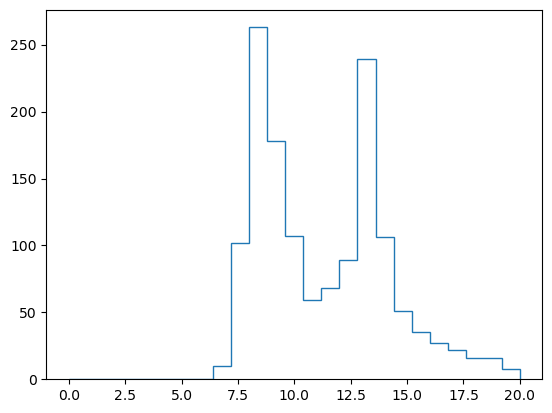

In [260]:
fig, ax = plt.subplots()
predictor.plot_histogram_d(state=predictor.sampled_states[1], initial_inputs=predictor.sampled_initial_inputs[1], ax=ax, range=[0,20])

Text(0.5, 1.0, 'Prediction Error without Weighting Method')

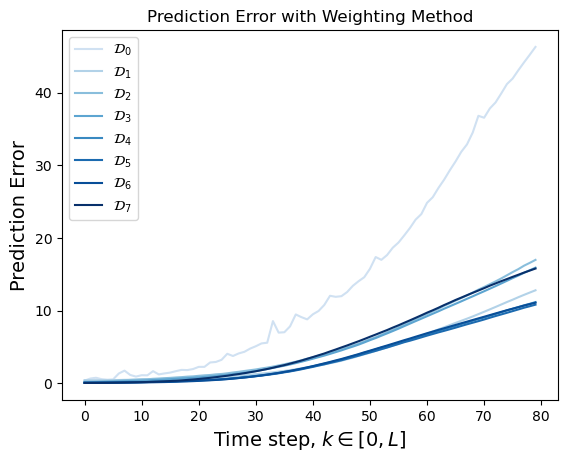

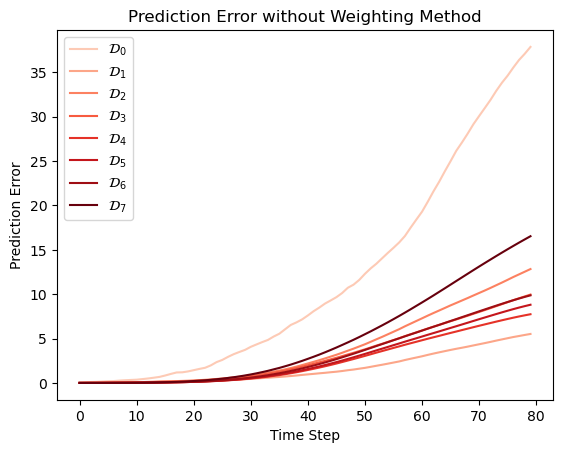

In [261]:
colors_for_datasets = plt.cm.Blues(np.linspace(0.2, 1, np.shape(error_lists_datasets)[0]))
fig, ax = plt.subplots()
for i in range(np.shape(error_lists_datasets)[0]):
    ax.plot(error_lists_datasets[i], color=colors_for_datasets[i], label=f"$\mathcal{{D}}_{i}$")

ax.legend()
ax.set_xlabel("Time step, $k \in [0, L]$", fontsize=14)
ax.set_ylabel("Prediction Error", fontsize=14)
ax.set_title("Prediction Error with Weighting Method")
# ax.set_ylim([0, 0.3e7])

plain_colors_for_datasets = plt.cm.Reds(np.linspace(0.2, 1, np.shape(plain_error_lists_datasets)[0]))
fig, ax = plt.subplots()
for i in range(np.shape(plain_error_lists_datasets)[0]):
    ax.plot(plain_error_lists_datasets[i], color=plain_colors_for_datasets[i], label=f"$\mathcal{{D}}_{i}$")

ax.legend()
ax.set_xlabel("Time Step")
ax.set_ylabel("Prediction Error")
ax.set_title("Prediction Error without Weighting Method")
# ax.set_ylim([0, 0.3e7])

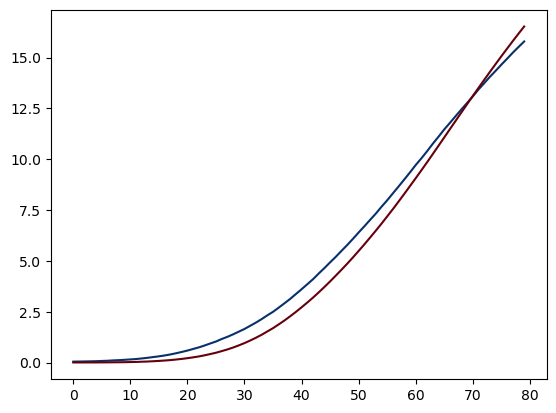

In [262]:
fig, ax = plt.subplots()
ax.plot(error_lists_datasets[-1], color=colors_for_datasets[-1], label="With Weighting")
ax.plot(plain_error_lists_datasets[-1], color=plain_colors_for_datasets[-1], label="Without Weighting")

In [263]:
error_lists_datasets_1 = np.empty(shape=(0, predictor.L))


# n_datasets = 5
for io_data_lists in dataset_list_to_analyse[-n_datasets:]:
    predictor.io_data_list = io_data_lists[i_seg]
    print(len(io_data_lists[i_seg]))

    # predictor.f = lambda d: 1/(d)**2
    # predictor.f = lambda d: 1/d
    # predictor.f = lambda d: np.exp(-d**2)
    predictor.f = lambda d: np.exp(-d**2) + 0.5
    # predictor.f = lambda d: np.exp(-d**2) + 1/(d)**2
    # predictor.f = lambda d: 1
    predictor.d_range = 10.0
    predictor.min_num_slices = 150
    predictor.portion_slices = 0.01
    method_dict, state_error_list = predictor.get_prediction_error()
    mean_error_list = np.nanmean(state_error_list, axis=0)
    error_lists_datasets_1 = np.vstack((error_lists_datasets_1, mean_error_list))
    print(method_dict)

3
Counter({'GivenDistance': 65, 'SliceNumber': 35})
5
Counter({'GivenDistance': 69, 'SliceNumber': 31})
7
Counter({'GivenDistance': 84, 'SliceNumber': 16})
9
Counter({'GivenDistance': 87, 'SliceNumber': 13})
11
Counter({'GivenDistance': 91, 'SliceNumber': 9})
13
Counter({'GivenDistance': 93, 'SliceNumber': 7})
15
Counter({'GivenDistance': 94, 'SliceNumber': 6})
36
Counter({'GivenDistance': 91, 'SliceNumber': 9})


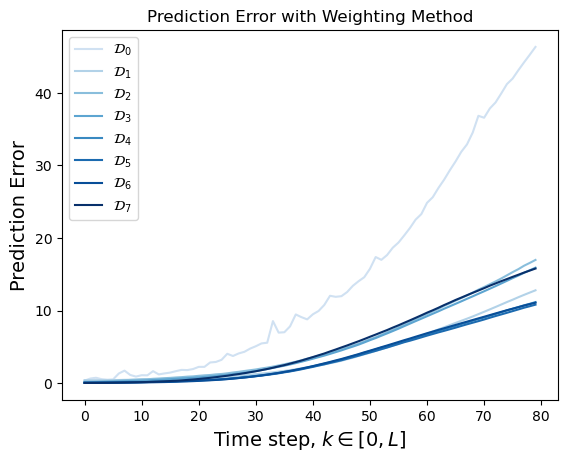

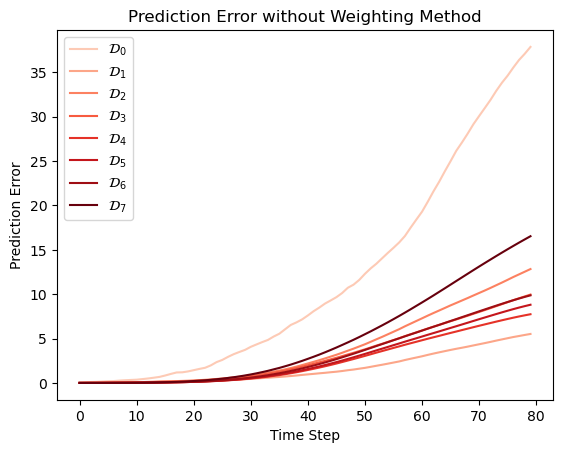

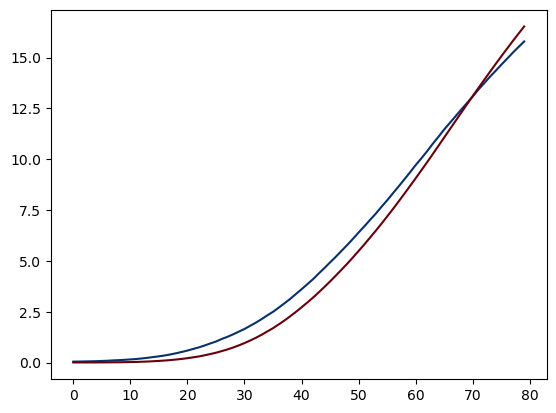

In [264]:
colors_for_datasets = plt.cm.Blues(np.linspace(0.2, 1, n_datasets))
fig, ax = plt.subplots()
for i in range(np.shape(error_lists_datasets_1)[0]):
    ax.plot(error_lists_datasets_1[i], color=colors_for_datasets[i], label=f"$\mathcal{{D}}_{i}$")

ax.legend()
ax.set_xlabel("Time step, $k \in [0, L]$", fontsize=14)
ax.set_ylabel("Prediction Error", fontsize=14)
ax.set_title("Prediction Error with Weighting Method")
# ax.set_ylim([0, 0.3e7])

plain_colors_for_datasets = plt.cm.Reds(np.linspace(0.2, 1, n_datasets))
fig, ax = plt.subplots()
for i in range(np.shape(plain_colors_for_datasets)[0]):
    ax.plot(plain_error_lists_datasets[i], color=plain_colors_for_datasets[i], label=f"$\mathcal{{D}}_{i}$")

ax.legend()
ax.set_xlabel("Time Step")
ax.set_ylabel("Prediction Error")
ax.set_title("Prediction Error without Weighting Method")
# ax.set_ylim([0, 0.3e7])

fig, ax = plt.subplots()
ax.plot(error_lists_datasets_1[-1], color=colors_for_datasets[-1], label="With Weighting")
ax.plot(plain_error_lists_datasets[-1], color=plain_colors_for_datasets[-1], label="Without Weighting")

In [265]:
error_lists_datasets_2 = np.empty(shape=(0, predictor.L))


# n_datasets = 5
for io_data_lists in dataset_list_to_analyse[-n_datasets:]:
    predictor.io_data_list = io_data_lists[i_seg]
    print(len(io_data_lists[i_seg]))

    # predictor.f = lambda d: 1/(d)**2
    # predictor.f = lambda d: 1/d + 1
    # predictor.f = lambda d: np.exp(-d**2)
    predictor.f = lambda d: np.exp(-d**2) + 2
    # predictor.f = lambda d: np.exp(-d**2) + 1/(d)**2
    # predictor.f = lambda d: 1
    predictor.d_range = 10.0
    predictor.min_num_slices = 150
    predictor.portion_slices = 0.01
    method_dict, state_error_list = predictor.get_prediction_error()
    mean_error_list = np.nanmean(state_error_list, axis=0)
    error_lists_datasets_2 = np.vstack((error_lists_datasets_2, mean_error_list))
    print(method_dict)

3
Counter({'GivenDistance': 65, 'SliceNumber': 35})
5
Counter({'GivenDistance': 69, 'SliceNumber': 31})
7
Counter({'GivenDistance': 84, 'SliceNumber': 16})
9
Counter({'GivenDistance': 87, 'SliceNumber': 13})
11
Counter({'GivenDistance': 91, 'SliceNumber': 9})
13
Counter({'GivenDistance': 93, 'SliceNumber': 7})
15
Counter({'GivenDistance': 94, 'SliceNumber': 6})
36
Counter({'GivenDistance': 91, 'SliceNumber': 9})


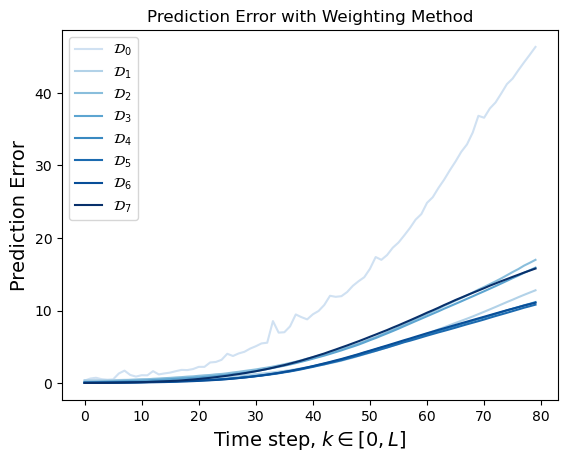

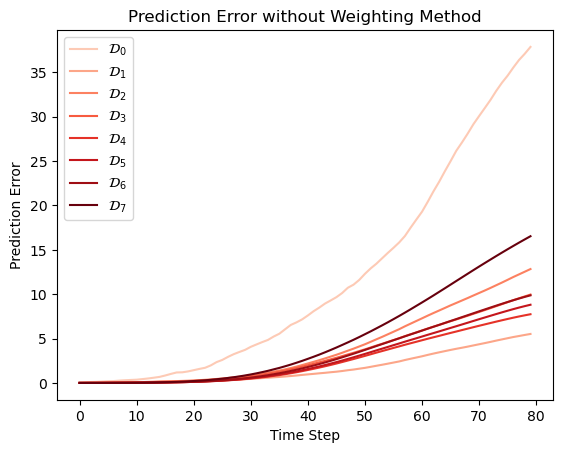

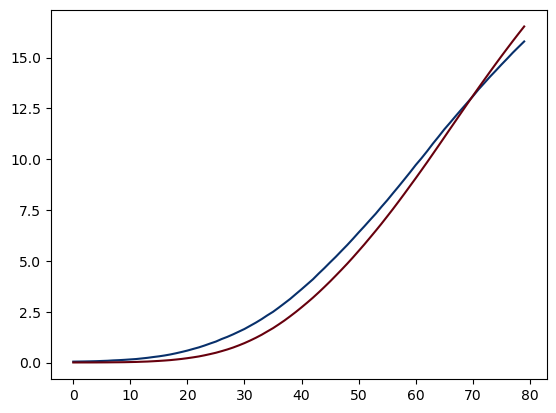

In [266]:
colors_for_datasets = plt.cm.Blues(np.linspace(0.2, 1, n_datasets))
fig, ax = plt.subplots()
for i in range(n_datasets):
    ax.plot(error_lists_datasets_2[i], color=colors_for_datasets[i], label=f"$\mathcal{{D}}_{i}$")

ax.legend()
ax.set_xlabel("Time step, $k \in [0, L]$", fontsize=14)
ax.set_ylabel("Prediction Error", fontsize=14)
ax.set_title("Prediction Error with Weighting Method")
# ax.set_ylim([0, 0.3e7])

plain_colors_for_datasets = plt.cm.Reds(np.linspace(0.2, 1, n_datasets))
fig, ax = plt.subplots()
for i in range(n_datasets):
    ax.plot(plain_error_lists_datasets[i], color=plain_colors_for_datasets[i], label=f"$\mathcal{{D}}_{i}$")

ax.legend()
ax.set_xlabel("Time Step")
ax.set_ylabel("Prediction Error")
ax.set_title("Prediction Error without Weighting Method")
# ax.set_ylim([0, 0.3e7])

fig, ax = plt.subplots()
ax.plot(error_lists_datasets_2[-1], color=colors_for_datasets[-1], label="With Weighting")
ax.plot(plain_error_lists_datasets[-1], color=plain_colors_for_datasets[-1], label="Without Weighting")

In [267]:
error_lists_datasets_3 = np.empty(shape=(0, predictor.L))


# n_datasets = 5
for io_data_lists in dataset_list_to_analyse[-n_datasets:]:
    predictor.io_data_list = io_data_lists[i_seg]
    print(len(io_data_lists[i_seg]))

    # predictor.f = lambda d: 1/(d)**2
    # predictor.f = lambda d: 1/d
    # predictor.f = lambda d: np.exp(-d**2)
    predictor.f = lambda d: np.exp(-d) + 0.5
    # predictor.f = lambda d: np.exp(-d**2) + 1/(d)**2
    # predictor.f = lambda d: 1
    predictor.d_range = 10.0
    predictor.min_num_slices = 150
    predictor.portion_slices = 0.01
    method_dict, state_error_list = predictor.get_prediction_error()
    mean_error_list = np.nanmean(state_error_list, axis=0)
    error_lists_datasets_3 = np.vstack((error_lists_datasets_3, mean_error_list))
    print(method_dict)

3
Counter({'GivenDistance': 65, 'SliceNumber': 35})
5
Counter({'GivenDistance': 69, 'SliceNumber': 31})
7
Counter({'GivenDistance': 84, 'SliceNumber': 16})
9
Counter({'GivenDistance': 87, 'SliceNumber': 13})
11
Counter({'GivenDistance': 91, 'SliceNumber': 9})
13
Counter({'GivenDistance': 93, 'SliceNumber': 7})
15
Counter({'GivenDistance': 94, 'SliceNumber': 6})
36
Counter({'GivenDistance': 91, 'SliceNumber': 9})


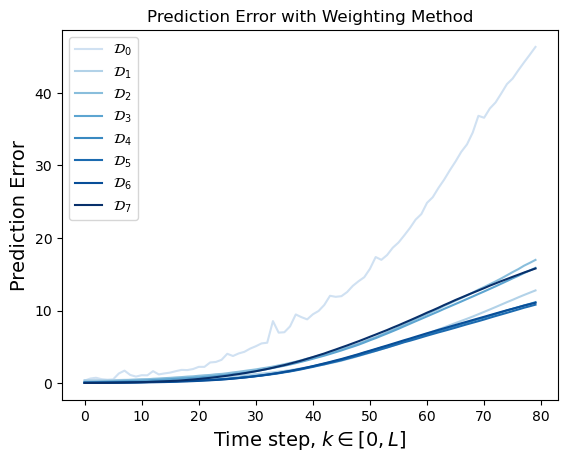

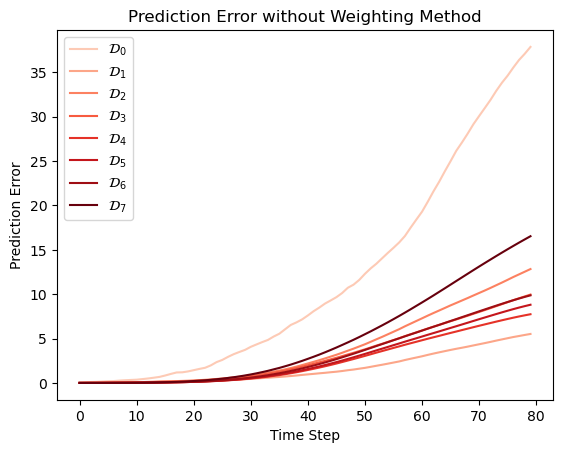

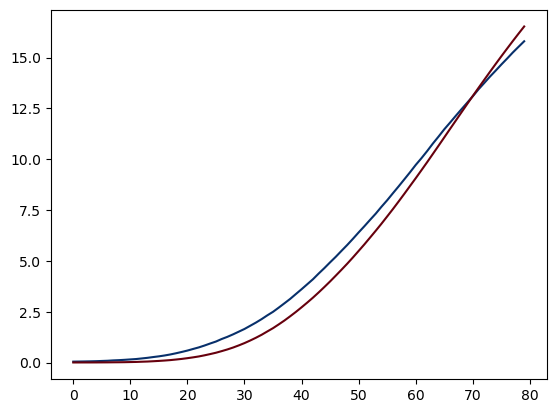

In [268]:
colors_for_datasets = plt.cm.Blues(np.linspace(0.2, 1, n_datasets))
fig, ax = plt.subplots()
for i in range(n_datasets):
    ax.plot(error_lists_datasets_3[i], color=colors_for_datasets[i], label=f"$\mathcal{{D}}_{i}$")

ax.legend()
ax.set_xlabel("Time step, $k \in [0, L]$", fontsize=14)
ax.set_ylabel("Prediction Error", fontsize=14)
ax.set_title("Prediction Error with Weighting Method")
# ax.set_ylim([0, 0.3e7])

plain_colors_for_datasets = plt.cm.Reds(np.linspace(0.2, 1, n_datasets))
fig, ax = plt.subplots()
for i in range(n_datasets):
    ax.plot(plain_error_lists_datasets[i], color=plain_colors_for_datasets[i], label=f"$\mathcal{{D}}_{i}$")

ax.legend()
ax.set_xlabel("Time Step")
ax.set_ylabel("Prediction Error")
ax.set_title("Prediction Error without Weighting Method")
# ax.set_ylim([0, 0.3e7])

fig, ax = plt.subplots()
ax.plot(error_lists_datasets_3[-1], color=colors_for_datasets[-1], label="With Weighting")
ax.plot(plain_error_lists_datasets[-1], color=plain_colors_for_datasets[-1], label="Without Weighting")

In [269]:
from tools.dataset_analyse import normalize_locs_list
from tools.FractalDimension import local_fractal_dimension

lag_fractal = 1
L_fractal = 0
minimal_length = predictor.L + predictor.lag
i_seg = 1
locs_list = []
inverse_size_of_region = np.sqrt(np.diag(predictor.weight_y))
print(inverse_size_of_region)
print('\n')
for datasets_for_segments in dataset_list:
    print(len(datasets_for_segments))
    dataset_list_for_segment = datasets_for_segments[i_seg]
    valid_dataset_list_for_segment = []
    for io_data in dataset_list_for_segment:
        if io_data.length >= minimal_length:
            valid_dataset_list_for_segment.append(io_data)
    
    H_uy_noised, _ = get_datasets_hankel_matrix(valid_dataset_list_for_segment, lag=lag_fractal, L=L_fractal)
    locs = np.array(H_uy_noised[m:].T)
    print(locs.shape)
    region_min = np.min(locs, axis=0)
    region_max = np.max(locs, axis=0)
    print(region_min)
    print(region_max)
    print(region_max-region_min)
    middle = (region_max + region_min)/2
    locs = (locs - middle)*inverse_size_of_region + middle
    # locs = normalize_locs_list([locs], region_min, region_max)[0]
    print(np.min(locs, axis=0))
    print(np.max(locs, axis=0))
    locs_list.append(locs)

middle_points, fractal_dimension_list = local_fractal_dimension(locs_list, size_min=-4.5, size_max=0.5, size_length=0.8)

[2.         0.31830989 0.37735849 0.25       1.25      ]


2
(618, 5)
[-0.04962628 -0.44064246 -0.18239654 -0.09282859 -0.08621808]
[0.17583912 0.33283288 1.23849288 0.15964879 3.01441942]
[0.2254654  0.77347534 1.42088942 0.25247739 3.1006375 ]
[-0.16235898 -0.17700722  0.25995583  0.00185043 -0.47379777]
[0.28857182 0.06919763 0.79614052 0.06496977 3.40199911]
2
(946, 5)
[-0.16799309 -0.44064246 -0.18239654 -0.09282859 -0.14775857]
[0.20069691 0.35077254 1.47355197 0.15964879 3.0307506 ]
[0.36869    0.791415   1.65594851 0.25247739 3.17850917]
[-0.3523381  -0.17089257  0.3331346   0.00185043 -0.54507221]
[0.38504191 0.08102264 0.95802083 0.06496977 3.42806425]
2
(1286, 5)
[-0.20300753 -0.44064246 -0.18239654 -0.09282859 -0.14775857]
[0.20069691 0.35077254 1.47355197 0.15964879 3.0307506 ]
[0.40370444 0.791415   1.65594851 0.25247739 3.17850917]
[-0.40485975 -0.17089257  0.3331346   0.00185043 -0.54507221]
[0.40254913 0.08102264 0.95802083 0.06496977 3.42806425]
2
(1618, 5)
[-0.203007

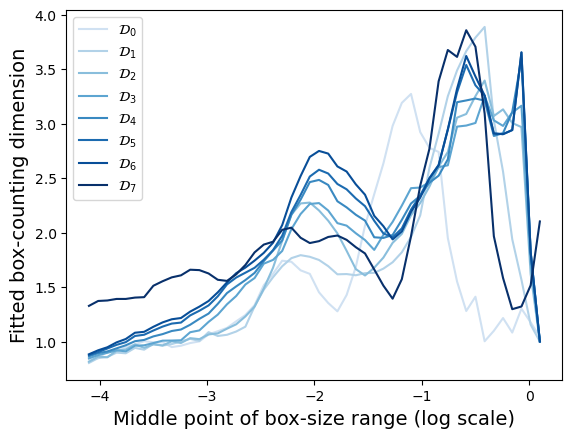

In [270]:
colors_for_datasets = plt.cm.Blues(np.linspace(0.2, 1, len(fractal_dimension_list)))
fig, ax = plt.subplots()
for i in range(len(fractal_dimension_list)):
    fractal_dimensions = fractal_dimension_list[i]
    ax.plot(middle_points, fractal_dimensions, color=colors_for_datasets[i], label=f"$\mathcal{{D}}_{i}$")
ax.legend()
ax.set_ylabel(r"Fitted box-counting dimension", fontsize=14)
ax.set_xlabel(r"Middle point of box-size range (log scale)", fontsize=14)
plt.savefig('fig/box-counting-dimension-dynamic-test.pdf', bbox_inches='tight')

In [271]:
# parameters used for analysing dataset

size_xi = len(xi_to_analyse)
size_uy = len(u_pf_y_p_to_analyse)
print(size_xi, size_uy)

W_xi = np.matrix(np.eye(size_xi))
W_uy = np.matrix(np.eye(size_uy))
f = lambda x: 0.01/x

lag = 10
L = 85

weighting_xi_list: List[float] = []
weighting_uy_list: List[float] = []
for dataset_list_for_track in dataset_list:
    dataset_list_for_seg = dataset_list_for_track[i_seg]
    print([data.length for data in dataset_list_for_seg])

    # evalueate the weighting matrix for xi
    weighting_xi = weighting_xi_in_datasets(W_xi=W_xi, f=f, io_data_list=dataset_list_for_seg, lag=lag, L=L, l_p=sampler.l_p, l_f=sampler.l_f, xi=xi_to_analyse)
    weighting_xi_list.append(weighting_xi)
    print(f"The weight of xi: {weighting_xi}")

    # evalueate the weighting matrix for u_pf_y_p
    weighting_uy = weighting_u_pf_y_p_in_datasets(W=W_uy, f=f, io_data_list=dataset_list_for_seg, lag=lag, L=L, l_p=sampler.l_p, l_f=sampler.l_f, u_pf_y_p=u_pf_y_p_to_analyse)
    weighting_uy_list.append(weighting_uy)
    print(f"The weight of u_pf_y_p: {weighting_uy}")

    # try monte carlo integral
    # start = timer()
    values = []
    errors = []
    for n in [5, 100, 10000]:
        integrand = lambda x: weighting_xi_in_datasets(W_xi=W_xi, f=f, io_data_list=dataset_list_for_seg, lag=lag, L=L, l_p=sampler.l_p, l_f=sampler.l_f, xi=x)
        value, error = monte_carlo_integrate(integrand, sampler.xi_iterator(), n=n)
        values.append(value)
        errors.append(error)
        print((value, error))
    print(f"Value for xi integral: {values}, error: {errors}")
    # end = timer()
    # print(f"Time for xi integral: {end-start}")

    # start = timer()
    values = []
    errors = []
    for n in [5, 10, 100, 10000]:
        integrand = lambda x: weighting_u_pf_y_p_in_datasets(W=W_uy, f=f, io_data_list=dataset_list_for_seg, lag=lag, L=L, l_p=sampler.l_p, l_f=sampler.l_f, u_pf_y_p=x)
        value, error = monte_carlo_integrate(integrand, sampler.u_pf_y_p_iterator(), n=n)
        values.append(value)
        errors.append(error)
        print((value, error))
    print(f"Value for u_pf_y_p integral: {values}, error: {errors}")
    # end = timer()
    # print(f"Time for u_pf_y_p integral: {end-start}")
    print("--------------------------------------------------")


NameError: name 'xi_to_analyse' is not defined